# Acoustic Anomaly Detection with Azure Machine Learning
## 10. AutoML Classification using audio features

<img src="https://github.com/retkowsky/Audio_Analytics_With_AzureML/raw/main/image.jpg" width = 800>

<div class="alert alert-info"><b> Let's use Azure AutoML to classify audio files using audio features extraction.</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 01-Jun-2022 | V2

### We need librosa for audio features extraction

In [1]:
try:
    import librosa
    print("Librosa is available")

except ImportError as e:
    print("Librosa is not installed")
    print("Run this command to install librosa: conda install -c conda-forge librosa")
    pass

Librosa is available


In [2]:
import json
import logging
import pandas as pd
import os
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient
from matplotlib import pyplot as plt
import requests
from numpy import array
import numpy as np
import datetime
import librosa
import librosa.display
import IPython
import seaborn as sns
import scipy

## 1. Settings

In [3]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [4]:
ws = Workspace.from_config()

print("Azure ML workspace:", ws.name)
print("Azure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlsound
Azure ML resource group: azuremlsound-rg


In [5]:
print("Azure ML version is:", azureml.core.VERSION)
print("This notebook was made with Azure ML 1.41.0")

Azure ML version is: 1.41.0
This notebook was made with Azure ML 1.41.0


In [6]:
experiment_name = 'AutoML-MachineSoundClassification'

In [7]:
experiment=Experiment(ws, experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
AutoML-MachineSoundClassification,azuremlsound,Link to Azure Machine Learning studio,Link to Documentation


## 2. Saving Audio features CSV and xls files into Azure ML Datastore

In [8]:
# Our audio features extraction files
!ls featuresresults/*.* -lh

-rwxrwxrwx 1 root root 131K May 31 09:24 featuresresults/machineaudiofeatures.csv


In [9]:
ds = ws.get_default_datastore()

ds.upload_files(files = ['./featuresresults/machineaudiofeatures.csv'], # Upload the diabetes csv files in /data
                        target_path = 'machineaudiofeatures', # Put it in a folder path in the datastore
                        overwrite = True, # Replace existing files of the same name
                        show_progress = True)

"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading ./featuresresults/machineaudiofeatures.csv
Uploaded ./featuresresults/machineaudiofeatures.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_e4afaa5e664646e788475b4b39eb8ff6

## 3. Loading files from the Azure ML datastore

In [10]:
# Load Azure ML datasource

machineaudiofeatures_ds = Dataset.Tabular.from_delimited_files(
    path=ds.path('machineaudiofeatures/machineaudiofeatures.csv'))

In [11]:
# convert datasource to pandas df

machineaudiofeatures_df = machineaudiofeatures_ds.to_pandas_dataframe()

In [12]:
machineaudiofeatures_df.shape

(122, 84)

In [13]:
# Removing some columns for the model

del machineaudiofeatures_df['Column1']
del machineaudiofeatures_df['fullfilename']
del machineaudiofeatures_df['dirsname']
del machineaudiofeatures_df['filename']
del machineaudiofeatures_df['basename']
del machineaudiofeatures_df['extension']
del machineaudiofeatures_df['sampling_rate']
del machineaudiofeatures_df['total_samples']
del machineaudiofeatures_df['duration']

In [14]:
machineaudiofeatures_df.shape

(122, 75)

In [15]:
machineaudiofeatures_df.columns

Index(['category', 'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2',
       'chroma_mean_3', 'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6',
       'chroma_mean_7', 'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10',
       'chroma_mean_11', 'chroma_std_0', 'chroma_std_1', 'chroma_std_2',
       'chroma_std_3', 'chroma_std_4', 'chroma_std_5', 'chroma_std_6',
       'chroma_std_7', 'chroma_std_8', 'chroma_std_9', 'chroma_std_10',
       'chroma_std_11', 'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2',
       'mfccs_mean_3', 'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6',
       'mfccs_mean_7', 'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10',
       'mfccs_mean_11', 'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1',
       'mfccs_std_2', 'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5',
       'mfccs_std_6', 'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9',
       'mfccs_std_10', 'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std',
       'cent_skew', 'contrast_mean_0', 'contrast_mean_1', 'cont

In [16]:
machineaudiofeatures_df

,category,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,KO,0.207503,0.089211,0.014424,0.000000,0.000772,0.232380,0.278296,0.013889,0.024552,...,1.687249,1.348917,1.956130,4519.334482,440.507933,440.507933,0.042180,0.007172,0.254478,89.102909
1,KO,0.254620,0.063713,0.014474,0.000000,0.000000,0.192064,0.296652,0.008270,0.013236,...,1.659869,1.223647,1.890165,4615.663480,400.850709,400.850709,0.044206,0.007007,-0.040588,89.102909
2,KO,0.209314,0.016753,0.010935,0.006343,0.006212,0.293131,0.210439,0.008586,0.015414,...,1.754098,1.625430,1.688382,4621.011130,535.484051,535.484051,0.044763,0.008382,0.570683,89.102909
3,KO,0.256801,0.056586,0.013729,0.004022,0.014325,0.213509,0.305680,0.009044,0.016558,...,1.821550,1.315156,1.914569,4550.315200,513.303975,513.303975,0.044505,0.007688,0.149309,129.199219
4,KO,0.260920,0.071828,0.022676,0.004175,0.002394,0.184932,0.300723,0.006286,0.015681,...,1.809823,1.435966,2.025108,4610.993200,444.503034,444.503034,0.045001,0.007708,0.176262,89.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,OK,0.225548,0.107287,0.023337,0.001401,0.091022,0.237812,0.213886,0.031082,0.099134,...,1.577742,1.220364,1.666872,4949.928555,470.857987,470.857987,0.056251,0.010129,-0.107818,103.359375
118,OK,0.217112,0.129246,0.060959,0.016421,0.118479,0.244478,0.130089,0.016905,0.036819,...,1.645010,1.255997,1.848186,4814.239542,429.000220,429.000220,0.051451,0.008525,0.026363,89.102909
119,OK,0.269449,0.096290,0.032997,0.015310,0.027349,0.195126,0.300515,0.023389,0.003816,...,1.549956,1.181879,1.830801,4493.879669,291.260123,291.260123,0.039979,0.006809,0.544547,143.554688
120,OK,0.188875,0.042767,0.014092,0.001497,0.016993,0.349846,0.222005,0.006505,0.036559,...,1.658569,1.224671,1.826454,4604.290812,407.445736,407.445736,0.041873,0.006133,0.030066,89.102909


## 4. Let's start just using a SVM model on the features to predict the class (OK, KO)

In [17]:
from sklearn.model_selection import train_test_split

# Partionning the dataset
X_train, X_test, y_train, y_test = train_test_split(machineaudiofeatures_df.drop('category', 
                                                                                 axis = 1), 
                                                    machineaudiofeatures_df['category'], 
                                                    test_size = 0.3, 
                                                    random_state = 123456789)

In [18]:
from sklearn import svm

# Create a svm Classifier
svm = svm.SVC(kernel = 'linear') # Linear Kernel

# Train the model using the training sets
svm.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = svm.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print("SVM Confusion Matrix:\n")
print("\033[1;31;34m", confusion_matrix(y_test, y_pred))

SVM Confusion Matrix:

 [[16  6]
 [ 1 14]]


<IPython.core.display.Javascript object>


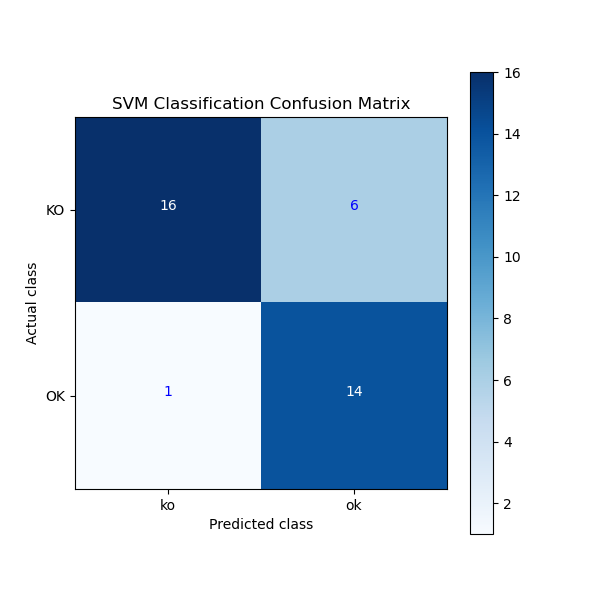

In [21]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize = (6, 6))
cf = confusion_matrix(y_test, y_pred)
plt.imshow(cf, cmap = plt.cm.Blues, interpolation = 'nearest')
plt.colorbar()
plt.title('SVM Classification Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')

class_labels = ['ko', 'ok']

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([0, 1, ], 
           ['KO', 'OK'])

thresh = cf.max() / 2.

for i,j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(j, i, format(cf[i, j],'d'), horizontalalignment = 'center', color = 'white' if cf[i, j] > thresh else 'blue')

plt.show()

In [22]:
print("SVM Classification report:\n")
print(classification_report(y_test, y_pred, digits = 3))

SVM Classification report:

              precision    recall  f1-score   support

          KO      0.941     0.727     0.821        22
          OK      0.700     0.933     0.800        15

    accuracy                          0.811        37
   macro avg      0.821     0.830     0.810        37
weighted avg      0.843     0.811     0.812        37



In [23]:
from sklearn.metrics import accuracy_score
svm_accuracy = accuracy_score(y_test, y_pred)
print("\033[1;31;34mSVM Accuracy =", round(svm_accuracy, 2))

SVM Accuracy = 0.81


## 5. Create or Attach existing AmlCompute
You will need to create a compute target for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [24]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "AutoML-CPU"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')

except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size = 'STANDARD_DS12_V2',
                                                           max_nodes = 6)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output = True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [25]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [26]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2022-05-31T12:59:19.732000+00:00',
 'errors': None,
 'creationTime': '2022-05-31T12:12:06.141175+00:00',
 'modifiedTime': '2022-05-31T12:12:10.826505+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 6,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_DS12_V2'}

In [27]:
# Compute VM size
compute_target.vm_size

'STANDARD_DS12_V2'

## 6. Training Data

We are going to store the df into an Azure ML datasource

In [28]:
machineaudiofeatures_df

,category,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,KO,0.207503,0.089211,0.014424,0.000000,0.000772,0.232380,0.278296,0.013889,0.024552,...,1.687249,1.348917,1.956130,4519.334482,440.507933,440.507933,0.042180,0.007172,0.254478,89.102909
1,KO,0.254620,0.063713,0.014474,0.000000,0.000000,0.192064,0.296652,0.008270,0.013236,...,1.659869,1.223647,1.890165,4615.663480,400.850709,400.850709,0.044206,0.007007,-0.040588,89.102909
2,KO,0.209314,0.016753,0.010935,0.006343,0.006212,0.293131,0.210439,0.008586,0.015414,...,1.754098,1.625430,1.688382,4621.011130,535.484051,535.484051,0.044763,0.008382,0.570683,89.102909
3,KO,0.256801,0.056586,0.013729,0.004022,0.014325,0.213509,0.305680,0.009044,0.016558,...,1.821550,1.315156,1.914569,4550.315200,513.303975,513.303975,0.044505,0.007688,0.149309,129.199219
4,KO,0.260920,0.071828,0.022676,0.004175,0.002394,0.184932,0.300723,0.006286,0.015681,...,1.809823,1.435966,2.025108,4610.993200,444.503034,444.503034,0.045001,0.007708,0.176262,89.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,OK,0.225548,0.107287,0.023337,0.001401,0.091022,0.237812,0.213886,0.031082,0.099134,...,1.577742,1.220364,1.666872,4949.928555,470.857987,470.857987,0.056251,0.010129,-0.107818,103.359375
118,OK,0.217112,0.129246,0.060959,0.016421,0.118479,0.244478,0.130089,0.016905,0.036819,...,1.645010,1.255997,1.848186,4814.239542,429.000220,429.000220,0.051451,0.008525,0.026363,89.102909
119,OK,0.269449,0.096290,0.032997,0.015310,0.027349,0.195126,0.300515,0.023389,0.003816,...,1.549956,1.181879,1.830801,4493.879669,291.260123,291.260123,0.039979,0.006809,0.544547,143.554688
120,OK,0.188875,0.042767,0.014092,0.001497,0.016993,0.349846,0.222005,0.006505,0.036559,...,1.658569,1.224671,1.826454,4604.290812,407.445736,407.445736,0.041873,0.006133,0.030066,89.102909


In [29]:
machineaudiofeatures_df.columns

Index(['category', 'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2',
       'chroma_mean_3', 'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6',
       'chroma_mean_7', 'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10',
       'chroma_mean_11', 'chroma_std_0', 'chroma_std_1', 'chroma_std_2',
       'chroma_std_3', 'chroma_std_4', 'chroma_std_5', 'chroma_std_6',
       'chroma_std_7', 'chroma_std_8', 'chroma_std_9', 'chroma_std_10',
       'chroma_std_11', 'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2',
       'mfccs_mean_3', 'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6',
       'mfccs_mean_7', 'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10',
       'mfccs_mean_11', 'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1',
       'mfccs_std_2', 'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5',
       'mfccs_std_6', 'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9',
       'mfccs_std_10', 'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std',
       'cent_skew', 'contrast_mean_0', 'contrast_mean_1', 'cont

In [30]:
mydir = 'audiofeatures'

if os.path.isdir(mydir) == False:
    os.mkdir(mydir)

In [31]:
local_path = 'audiofeatures/machineaudiofeatures_df.csv'
machineaudiofeatures_df.to_csv(local_path)

In [32]:
from azureml.core import Workspace, Dataset

# get the datastore to upload prepared data
datastore = ws.get_default_datastore()
# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir = 'audiofeatures', target_path = 'audiofeatures', overwrite = True)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading audiofeatures/machineaudiofeatures_df.csv
Uploaded audiofeatures/machineaudiofeatures_df.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_c8655a4d560a4325b467555b5e2fb4ac

### Let's use the data source for the AutoML process

In [33]:
audio_ds = Dataset.Tabular.from_delimited_files(datastore.path('audiofeatures/machineaudiofeatures_df.csv'))

In [34]:
audio_ds=audio_ds.drop_columns('Column1')
audio_ds.to_pandas_dataframe()

,category,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,KO,0.207503,0.089211,0.014424,0.000000,0.000772,0.232380,0.278296,0.013889,0.024552,...,1.687249,1.348917,1.956130,4519.334482,440.507933,440.507933,0.042180,0.007172,0.254478,89.102909
1,KO,0.254620,0.063713,0.014474,0.000000,0.000000,0.192064,0.296652,0.008270,0.013236,...,1.659869,1.223647,1.890165,4615.663480,400.850709,400.850709,0.044206,0.007007,-0.040588,89.102909
2,KO,0.209314,0.016753,0.010935,0.006343,0.006212,0.293131,0.210439,0.008586,0.015414,...,1.754098,1.625430,1.688382,4621.011130,535.484051,535.484051,0.044763,0.008382,0.570683,89.102909
3,KO,0.256801,0.056586,0.013729,0.004022,0.014325,0.213509,0.305680,0.009044,0.016558,...,1.821550,1.315156,1.914569,4550.315200,513.303975,513.303975,0.044505,0.007688,0.149309,129.199219
4,KO,0.260920,0.071828,0.022676,0.004175,0.002394,0.184932,0.300723,0.006286,0.015681,...,1.809823,1.435966,2.025108,4610.993200,444.503034,444.503034,0.045001,0.007708,0.176262,89.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,OK,0.225548,0.107287,0.023337,0.001401,0.091022,0.237812,0.213886,0.031082,0.099134,...,1.577742,1.220364,1.666872,4949.928555,470.857987,470.857987,0.056251,0.010129,-0.107818,103.359375
118,OK,0.217112,0.129246,0.060959,0.016421,0.118479,0.244478,0.130089,0.016905,0.036819,...,1.645010,1.255997,1.848186,4814.239542,429.000220,429.000220,0.051451,0.008525,0.026363,89.102909
119,OK,0.269449,0.096290,0.032997,0.015310,0.027349,0.195126,0.300515,0.023389,0.003816,...,1.549956,1.181879,1.830801,4493.879669,291.260123,291.260123,0.039979,0.006809,0.544547,143.554688
120,OK,0.188875,0.042767,0.014092,0.001497,0.016993,0.349846,0.222005,0.006505,0.036559,...,1.658569,1.224671,1.826454,4604.290812,407.445736,407.445736,0.041873,0.006133,0.030066,89.102909


In [35]:
df = audio_ds.to_pandas_dataframe()

In [36]:
df['category'].value_counts()

OK    61
KO    61
Name: category, dtype: int64

## 7. Partitionning the data

In [37]:
splitpct = 0.7 # 70% for the training

In [38]:
training_dataset, validation_dataset = audio_ds.random_split(percentage = splitpct, 
                                                             seed = 123456789)

## 8. Azure AutoML for Classification to train the best classification model for detecting anomalies using audio features

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**blocked_models** | *List* of *strings* indicating machine learning algorithms for AutoML to avoid in this run. <br><br> Allowed values for **Classification**<br><i>LogisticRegression</i><br><i>SGD</i><br><i>MultinomialNaiveBayes</i><br><i>BernoulliNaiveBayes</i><br><i>SVM</i><br><i>LinearSVM</i><br><i>KNN</i><br><i>DecisionTree</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>GradientBoosting</i><br><i>TensorFlowDNN</i><br><i>TensorFlowLinearClassifier</i><br><br>Allowed values for **Regression**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><br>Allowed values for **Forecasting**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><i>Arima</i><br><i>Prophet</i>|
|**allowed_models** |  *List* of *strings* indicating machine learning algorithms for AutoML to use in this run. Same values listed above for **blocked_models** allowed for **allowed_models**.|
|**experiment_exit_score**| Value indicating the target for *primary_metric*. <br>Once the target is surpassed the run terminates.|
|**experiment_timeout_hours**| Maximum amount of time in hours that all iterations combined can take before the experiment terminates.|
|**enable_early_stopping**| Flag to enble early termination if the score is not improving in the short term.|
|**featurization**| 'auto' / 'off'  Indicator for whether featurization step should be done automatically or not. Note: If the input data is sparse, featurization cannot be turned on.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [39]:
label = 'category' # Label to predict

In [40]:
automl_settings = {
    "experiment_timeout_hours" : 0.5, # Max time in hours
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 10, # Timeout per iteration in minutes
    "max_concurrent_iterations": 4, # Max concurrent iterations
    "max_cores_per_iteration": -1, # All
    #"n_cross_validations": 3, # Cross validations if needed
    "primary_metric": 'AUC_weighted', # Metric to use
    "featurization": 'auto', # Featurization
    "iterations" : 10, # We can generate 10 iterations max
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification', # AutoML Task
                             debug_log = 'automl_errors.log', # log file
                             compute_target=compute_target, # Azure ML Compute target to use
                             #experiment_exit_score = 0.95, # Exit score if needed
                             #blocked_models = ['KNN','LinearSVM'], # Models to exclude if needed
                             enable_onnx_compatible_models = True,
                             training_data = training_dataset, # Training
                             label_column_name = label, # Target variable to predict
                             validation_data = validation_dataset, # Validation
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [41]:
t1 = datetime.datetime.now()
print(t1, "Running AutoML...")

remote_run = experiment.submit(automl_config, show_output = True)
remote_run.wait_for_completion()

print("Done in:", datetime.datetime.now() - t1)

2022-06-01 06:57:57.424122 Running AutoML...
Submitting remote run.
No run_configuration provided, running on AutoML-CPU with default configuration
Running on remote compute: AutoML-CPU


Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-MachineSoundClassification,AutoML_6f9ffe65-f63f-4efa-953a-cc8a03b30884,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTI

In [42]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [43]:
# Retrieve the best Run object
best_run = remote_run.get_best_child()
print("Best run:", best_run)

Best run: Run(Experiment: AutoML-MachineSoundClassification,
Id: AutoML_6f9ffe65-f63f-4efa-953a-cc8a03b30884_2,
Type: None,
Status: Completed)


## 9. Transparency

View featurization summary for the best model - to study how different features were transformed. This is stored as a JSON file in the outputs directory for the run.

In [44]:
MYDIR = 'automl_audiofeatures'

if os.path.isdir(MYDIR):
    print("Directory", MYDIR, "exists. So let's use it.")
    
if not os.path.isdir(MYDIR):
    print("Directory not exists. Creating directory... ", MYDIR)
    os.mkdir(MYDIR)
    print("Done.")

Directory automl_audiofeatures exists. So let's use it.


In [45]:
# Download the featurization summary JSON file locally
best_run.download_file("outputs/featurization_summary.json", 
                       "automl_audiofeatures/featurization_summary.json")

In [46]:
os.listdir(MYDIR)

['best_model.onnx', 'featurization_summary.json', 'onnx_resource.json']

In [47]:
with open("automl_audiofeatures/featurization_summary.json", "r") as f:
    records = json.load(f)

pd.DataFrame.from_records(records)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,chroma_mean_0,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['chroma_mean_0'], ..."
1,chroma_mean_1,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['chroma_mean_1'], ..."
2,chroma_mean_2,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['chroma_mean_2'], ..."
3,chroma_mean_3,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['chroma_mean_3'], ..."
4,chroma_mean_4,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['chroma_mean_4'], ..."
...,...,...,...,...,...,...
69,rolloff_skew,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['rolloff_skew'], '..."
70,zrate_mean,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['zrate_mean'], 'Tr..."
71,zrate_std,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['zrate_std'], 'Tra..."
72,zrate_skew,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['zrate_skew'], 'Tr..."


## 10. Results

### Retrieve the Best Model's explanation
Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed.

In [48]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run

model_explainability_run_id = remote_run.id + "_" + "ModelExplain"

print(model_explainability_run_id)
model_explainability_run = Run(experiment = experiment, run_id = model_explainability_run_id)
model_explainability_run.wait_for_completion()

# Get the best run object
best_run = remote_run.get_best_child()

AutoML_6f9ffe65-f63f-4efa-953a-cc8a03b30884_ModelExplain


#### Download engineered feature importance from artifact store
You can use ExplanationClient to download the engineered feature explanations from the artifact store of the best_run.

In [49]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()

exp_data

{'mfccs_std_3_MeanImputer': 1.310533386194276,
 'mfccs_std_2_MeanImputer': 1.2244462782962315,
 'mfccs_std_5_MeanImputer': 0.36984148909912695,
 'rolloff_std_MeanImputer': 0.27364897118505777,
 'mfccs_std_6_MeanImputer': 0.2192665817218063,
 'mfccs_std_4_MeanImputer': 0.17188559264456846,
 'contrast_std_0_MeanImputer': 0.13274984863003333,
 'contrast_std_1_MeanImputer': 0.12682883946434753,
 'contrast_std_3_MeanImputer': 0.12250520711038652,
 'chroma_std_0_MeanImputer': 0.11654208452103391,
 'contrast_mean_1_MeanImputer': 0.0927476412197349,
 'contrast_std_4_MeanImputer': 0.08841967909485086,
 'mfccs_mean_2_MeanImputer': 0.08208190263349606,
 'chroma_std_4_MeanImputer': 0.0818220048067867,
 'mfccs_std_1_MeanImputer': 0.0791400459108109,
 'mfccs_std_9_MeanImputer': 0.06879623169457114,
 'mfccs_mean_9_MeanImputer': 0.06846474858775753,
 'zrate_skew_MeanImputer': 0.05565022757066093,
 'chroma_std_3_MeanImputer': 0.05507370051287274,
 'mfccs_std_8_MeanImputer': 0.05050567982603854,
 'mfccs

#### Download raw feature importance from artifact store
You can use ExplanationClient to download the raw feature explanations from the artifact store of the best_run.

In [50]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()

exp_data

{'mfccs_std_3': 1.310533386194276,
 'mfccs_std_2': 1.2244462782962315,
 'mfccs_std_5': 0.36984148909912695,
 'rolloff_std': 0.27364897118505777,
 'mfccs_std_6': 0.2192665817218063,
 'mfccs_std_4': 0.17188559264456846,
 'contrast_std_0': 0.13274984863003333,
 'contrast_std_1': 0.12682883946434753,
 'contrast_std_3': 0.12250520711038652,
 'chroma_std_0': 0.11654208452103391,
 'contrast_mean_1': 0.0927476412197349,
 'contrast_std_4': 0.08841967909485086,
 'mfccs_mean_2': 0.08208190263349606,
 'chroma_std_4': 0.0818220048067867,
 'mfccs_std_1': 0.0791400459108109,
 'mfccs_std_9': 0.06879623169457114,
 'mfccs_mean_9': 0.06846474858775753,
 'zrate_skew': 0.05565022757066093,
 'chroma_std_3': 0.05507370051287274,
 'mfccs_std_8': 0.05050567982603854,
 'mfccs_std_11': 0.049414111727882445,
 'contrast_mean_0': 0.04802135839070516,
 'mfccs_mean_11': 0.04531048876257905,
 'rolloff_mean': 0.04486486681897304,
 'chroma_mean_10': 0.04229985499834129,
 'chroma_mean_7': 0.04025283061644788,
 'chroma_st

### Retrieve the Best ONNX Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [51]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model = True)

### Save the best ONNX model

In [52]:
from azureml.automl.runtime.onnx_convert import OnnxConverter

onnx_fl_path = "automl_audiofeatures/best_model.onnx" # Saving the ONNX model here
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

In [53]:
os.listdir(MYDIR)

['best_model.onnx', 'featurization_summary.json', 'onnx_resource.json']

### Predict with the ONNX model, using onnxruntime package

In [54]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'automl_audiofeatures/onnx_resource.json'
    run.download_file(name = constants.MODEL_RESOURCE_PATH_ONNX, output_file_path = res_path)
    with open(res_path) as f:
        result = json.load(f)
    return result

print("Predictions on the test datasets:\n")

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    test_df = validation_dataset.to_pandas_dataframe() # We will take here the validation ds as a test
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_result = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_result)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print("Predictions:\n", pred_onnx)
    print("\nConfidence:\n", pred_prob_onnx)

else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')

Predictions on the test datasets:

Predictions:
 ['KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO' 'KO'
 'KO' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK' 'OK'
 'OK' 'OK' 'OK' 'OK']

Confidence:
 [[0.96666664 0.03333334]
 [0.98571426 0.01428571]
 [0.6823809  0.31761906]
 [1.         0.        ]
 [1.         0.        ]
 [0.95       0.05      ]
 [0.96666664 0.03333334]
 [1.         0.        ]
 [0.98       0.02      ]
 [0.98333335 0.01666667]
 [0.66071427 0.33928573]
 [0.95       0.05      ]
 [0.98333335 0.01666667]
 [0.98333335 0.01666667]
 [1.         0.        ]
 [0.20261902 0.797381  ]
 [0.14095235 0.85904765]
 [0.16428566 0.83571434]
 [0.12785703 0.872143  ]
 [0.12999994 0.87000006]
 [0.1599999  0.8400001 ]
 [0.09999996 0.90000004]
 [0.21428567 0.7857143 ]
 [0.14999992 0.8500001 ]
 [0.37738097 0.62261903]
 [0.08809519 0.9119048 ]
 [0.11333328 0.8866667 ]
 [0.09523803 0.90476197]
 [0.47523808 0.5247619 ]
 [0.05999994 0.94000006]
 [0.05333328 0.9466667 

In [55]:
os.listdir(MYDIR)

['best_model.onnx', 'featurization_summary.json', 'onnx_resource.json']

### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [56]:
best_run = remote_run.get_best_child()

In [57]:
model_name = best_run.properties['model_name']
script_file_name = 'score.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'score.py')

In [58]:
!ls score.py -lh

-rwxrwxrwx 1 root root 6.1K Jun  1 07:12 score.py


In [59]:
with open('score.py', 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import json
import logging
import os
import pickle
import numpy as np
import pandas as pd
import joblib

import azureml.automl.core
from azureml.automl.core.shared import logging_utilities, log_server
from azureml.telemetry import INSTRUMENTATION_KEY

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType
from inference_schema.parameter_types.standard_py_parameter_type import StandardPythonParameterType

input_sample = pd.DataFrame({"chroma_mean_0": pd.Series([0.0], dtype="float64"), "chroma_mean_1": pd.Series([0.0], dtype="float64"), "chroma_mean_2": pd.Series([0.0], dtype="float64"), "chroma_mean_3": pd.Series([0.0], d

### Register the best AutoML Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [60]:
model_desc = "Best AutoML Machine Anomaly detection using audio features"
model_tags = {"area": "audio", 
              "type": "automl_classification", 
              "context": "Anomaly"}

print("Let's register the model:", model_name)
model = remote_run.register_model(model_name = model_name, 
                                  description = model_desc, 
                                  tags = model_tags)
print(remote_run.model_id)

Let's register the model: AutoML6f9ffe65f2
AutoML6f9ffe65f2


In [67]:
print('Name:', model.name)
print('Version:', model.version)
print('Tags:', model.tags)
print('Model Framework:', model.model_framework)
print('Model Framework Version:', model.model_framework_version)

Name: AutoML6f9ffe65f2
Version: 1
Tags: {'area': 'audio', 'type': 'automl_classification', 'context': 'Anomaly'}
Model Framework: Custom
Model Framework Version: None


## 11. Deploy the model as a Web Service on Azure Container Instance

In [68]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.model import Model

aci_service_name = "anomalyaudio-aci"
aci_tags = { "area": "audio", "type": "automl_classification", "context": "Anomaly" }
aci_desc = "AutoML Machine Anomaly detection using audio features"

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aci_config = AciWebservice.deploy_configuration(cpu_cores = 2, 
                                                memory_gb = 2,
                                                tags = aci_tags, 
                                                description = aci_desc)

In [69]:
print("Deploying the model into Azure Container Instance (ACI) as:", aci_service_name, '\n')

aci_service = Model.deploy(ws, 
                           aci_service_name, 
                           [model], 
                           inference_config, 
                           aci_config)

aci_service.wait_for_deployment(True)

Deploying the model into Azure Container Instance (ACI) as: anomalyaudio-aci 

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-01 07:14:54+00:00 Creating Container Registry if not exists.
2022-06-01 07:14:54+00:00 Registering the environment.
2022-06-01 07:14:55+00:00 Use the existing image.
2022-06-01 07:14:55+00:00 Generating deployment configuration.
2022-06-01 07:14:56+00:00 Submitting deployment to compute..
2022-06-01 07:15:07+00:00 Checking the status of deployment anomalyaudio-aci..
2022-06-01 07:20:10+00:00 Checking the status of inference endpoint anomalyaudio-aci.
Succeeded
ACI service creation operation finished, operation "Succeeded"


## Status

In [70]:
print("ACI service state:", aci_service.state)

ACI service state: Healthy


In [71]:
print(aci_service.scoring_uri)

http://f841bffc-a5a4-4bfe-85bf-06950caf96eb.westeurope.azurecontainer.io/score


### Get Logs from a Deployed Web Service

In [72]:
aci_service.get_logs()

'2022-06-01T07:19:22,335823600+00:00 - rsyslog/run \n2022-06-01T07:19:22,335355800+00:00 - iot-server/run \n2022-06-01T07:19:22,353532300+00:00 - gunicorn/run \n2022-06-01T07:19:22,392079500+00:00 | gunicorn/run | \n2022-06-01T07:19:22,393804200+00:00 - nginx/run \n2022-06-01T07:19:22,393894600+00:00 | gunicorn/run | ###############################################\n2022-06-01T07:19:22,412436200+00:00 | gunicorn/run | AzureML Container Runtime Information\n2022-06-01T07:19:22,416322300+00:00 | gunicorn/run | ###############################################\n2022-06-01T07:19:22,435845600+00:00 | gunicorn/run | \n2022-06-01T07:19:22,437938800+00:00 | gunicorn/run | \n2022-06-01T07:19:22,451373200+00:00 | gunicorn/run | AzureML image information: openmpi3.1.2-ubuntu18.04:20220516.v1\n2022-06-01T07:19:22,457683600+00:00 | gunicorn/run | \n2022-06-01T07:19:22,461426500+00:00 | gunicorn/run | \n2022-06-01T07:19:22,465376400+00:00 | gunicorn/run | PATH environment variable: /azureml-envs/azurem

## 12. Testing the ACI deployed model

Now that the model is trained, run the test data through the trained model to get the predicted values.  This calls the ACI web service to do the prediction.

Note that the JSON passed to the ACI web service is an array of rows of data.  Each row should either be an array of values in the same order that was used for training or a dictionary where the keys are the same as the column names used for training.  The example below uses dictionary rows.

In [73]:
test_dataset = validation_dataset
test_dataset.take(10).to_pandas_dataframe()

X_test_automl = test_dataset.drop_columns(columns = ['category'])
y_test_automl = test_dataset.keep_columns(columns = ['category'], validate = True)
X_test_automl = X_test_automl.to_pandas_dataframe()
y_test_automl = y_test_automl.to_pandas_dataframe()

### Evaluating the best model

In [74]:
X_test_json = X_test_automl.to_json(orient = 'records') #Json conversion
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(aci_service.scoring_uri, data, headers = headers) # Calling the ACI deployed model
y_pred_automl = json.loads(json.loads(resp.text))['result']

<IPython.core.display.Javascript object>


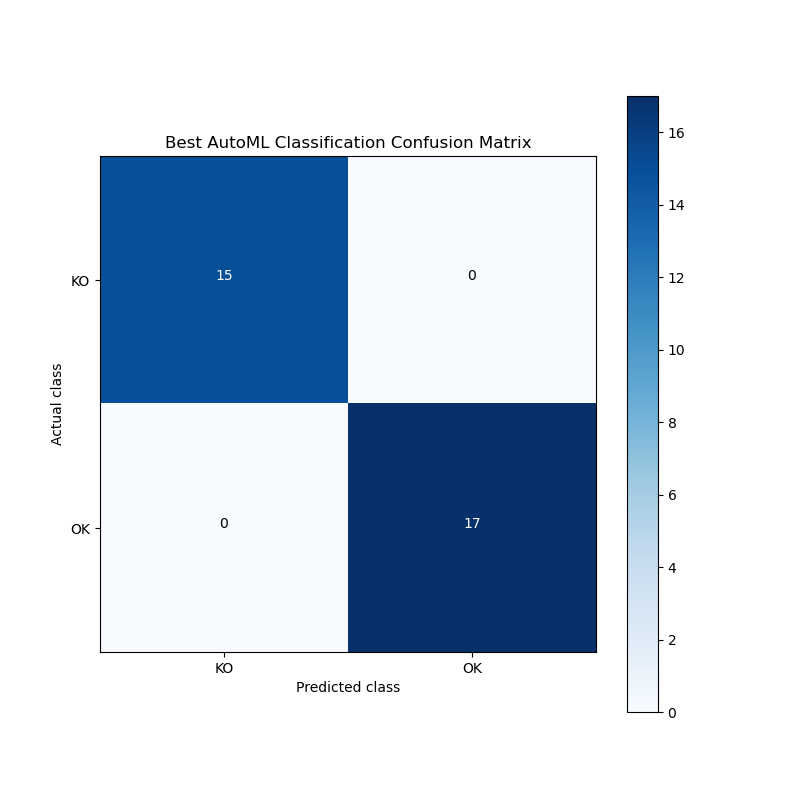

In [75]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize = (8, 8))
cf = confusion_matrix(y_test_automl, y_pred_automl)
plt.imshow(cf, cmap = plt.cm.Blues, interpolation = 'nearest')
plt.colorbar()

plt.title('Best AutoML Classification Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')

class_labels = ['KO', 'OK']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([0, 1], ['KO', 'OK'])

thresh = cf.max() / 2.

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(j, i, format(cf[i, j],'d'), horizontalalignment = 'center', 
             color = 'white' if cf[i, j] > thresh else 'black')
plt.show()

In [76]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test_automl, 
                            y_pred_automl, 
                            target_names = class_labels, 
                            digits = 3))

              precision    recall  f1-score   support

          KO      1.000     1.000     1.000        15
          OK      1.000     1.000     1.000        17

    accuracy                          1.000        32
   macro avg      1.000     1.000     1.000        32
weighted avg      1.000     1.000     1.000        32



In [77]:
automlaccuracy = accuracy_score(y_test_automl, 
                                y_pred_automl)

In [78]:
print("Best AutoML Accuracy =", round(automlaccuracy, 2))
print("SVM Accuracy =", round(svm_accuracy, 2))
ratio = ((automlaccuracy  / svm_accuracy) - 1 ) * 100
print("\nGain =", (round(ratio, 2)), '%')

Best AutoML Accuracy = 1.0
SVM Accuracy = 0.81

Gain = 23.33 %


In [79]:
os.listdir('test')

['machine_KO.wav', 'machine_OK.wav', 'spectogram.jpg']

In [84]:
def calling_automl_anomaly_model(audiofile):
    
    y, sr = librosa.load(audiofile)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y = y_harmonic, sr = sr)

    beat_times = librosa.frames_to_time(beat_frames, sr = sr)
    beat_time_diff = np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    chroma = librosa.feature.chroma_cens(y = y_harmonic, sr = sr)
    mfccs = librosa.feature.mfcc(y = y_harmonic, sr = sr, n_mfcc = 13)
    cent = librosa.feature.spectral_centroid(y = y, sr = sr)
    contrast = librosa.feature.spectral_contrast(y = y_harmonic, sr = sr)
    rolloff = librosa.feature.spectral_rolloff(y = y, sr= sr)
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    chroma_mean = np.mean(chroma, axis = 1)
    chroma_std = np.std(chroma, axis = 1)
    octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

    chroma_df=pd.DataFrame()

    for i in range(0, 12):
        chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]
    for i in range(0, 12):
        chroma_df['chroma_std_' + str(i)] = chroma_mean[i]
    
    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)
    mfccs_mean = np.mean(mfccs, axis = 1)
    mfccs_std = np.std(mfccs, axis = 1)

    coeffs = np.arange(0, 13)

    mfccs_df = pd.DataFrame()
    
    for i in range(0, 13):
        mfccs_df['mfccs_mean_' + str(i)] = mfccs_mean[i]
    
    for i in range(0, 13):
        mfccs_df['mfccs_std_' + str(i)] = mfccs_mean[i]
    
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)

    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis = 1)[0]

    contrast_mean = np.mean(contrast,axis = 1)
    contrast_std = np.std(contrast, axis = 1)
    conts = np.arange(0, 7)
    contrast_df = pd.DataFrame()

    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]
    
    spectral_df = pd.DataFrame()
    collist = ['cent_mean','cent_std','cent_skew']
    
    for i in range(0,7):
        collist.append('contrast_mean_' + str(i))
    
    for i in range(0,7):
        collist.append('contrast_std_' + str(i))
        collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
    
    for c in collist:
        spectral_df[c] = 0
    
    data = np.concatenate(([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,
                           [rolloff_mean, rolloff_std, rolloff_std]), axis = 0)
    spectral_df.loc[0] = data

    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

    zrate_df=pd.DataFrame()
    zrate_df['zrate_mean'] = 0
    zrate_df['zrate_std'] = 0
    zrate_df['zrate_skew'] = 0
    zrate_df.loc[0] = [zrate_mean, zrate_std, zrate_skew]

    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo

    sr_df = pd.DataFrame({'sampling_rate': [sr]})
    totalsamples = np.size(y)
    duration = totalsamples / sr
    totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
    duration_df = pd.DataFrame({'duration': [duration]})

    audiofeatures_soundfile = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis = 1)
    
    pd.set_option('max_columns', None)
    audiofeatures_soundfile
    
    # Calling the deployed model
    audiofeatures_soundfile_json = audiofeatures_soundfile.to_json(orient = 'records')

    data = "{\"data\": " + audiofeatures_soundfile_json +"}"
    headers = {'Content-Type': 'application/json'}

    resp = requests.post(aci_service.scoring_uri, data, headers = headers) # Calling the ACI deployed model
    resp_json = json.loads(resp.text)
    anomaly_results = json.loads(json.loads(resp.text))['result']

    print("Machine anomaly prediction of:", audiofile)
    
    if str.upper(anomaly_results[0]) == 'OK':
        print("\033[1;31;32m")
        print("Prediction:", str.upper(anomaly_results[0]))
        print("[OK] No sound anomaly has been detected in the audio file.")
    
    if str.upper(anomaly_results[0]) != 'OK':
        print("\033[1;31;91m")
        print("Prediction:", str.upper(anomaly_results[0]))
        print("[Alert] Sound anomaly has been detected in the audio file.")

    return anomaly_results

## Testing the model

In [81]:
!ls test/*.* -lh

-rwxrwxrwx 1 root root 1.2M May 31 10:26 test/machine_KO.wav
-rwxrwxrwx 1 root root 1.2M May 31 10:26 test/machine_OK.wav
-rwxrwxrwx 1 root root 570K May 31 09:07 test/spectogram.jpg


### Test 1

In [82]:
audiofile = "test/machine_KO.wav"
IPython.display.Audio(audiofile)

In [85]:
calling_automl_anomaly_model(audiofile)

Machine anomaly prediction of: test/machine_KO.wav

Prediction: KO
[Alert] Sound anomaly has been detected in the audio file.


['KO']

> A sound anomaly is detected!

### Test 2

In [86]:
audiofile = "test/machine_OK.wav"
IPython.display.Audio(audiofile)

In [87]:
calling_automl_anomaly_model(audiofile)

Machine anomaly prediction of: test/machine_OK.wav

Prediction: OK
[OK] No sound anomaly has been detected in the audio file.


['OK']

> No sound anomaly!

#### So we were able to predict sound anomaly using audio features and AutoML for Classification

## 14. Delete the Web Service
Deletes the specified web service (if needed)

In [88]:
aci_service.delete()

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/


> END